# 2-D Bin Packing

The algorithm we'll be implementing is from [Bansal et al. (2014)](https://pdfs.semanticscholar.org/8e28/d9f9b90825660c57bab99a6ad7ec1d22d755.pdf). This algorithm is given in section 4 of the paper and yields a 1.5-approximation using rounding. I'll see if it's applicable to this set up.

## Algorithm

Input: set of items $i \in I$, where each item $i$ has two dimensions defined by $j$ and $k$ (compute and memory). 

1. Guess the optimum by trying all values between $1$ and $n$.
2. For each guessed value of Opt, do:

    a. Compute $\delta$ to classify values and pack medium VM's using Next Fit Decreasing Height (NFDH).
    
    b. Enumerate over all sizes that are rounded to and for each size the number of items that are rounded to that size, of the set of big, long, wide rectangles and the set of wide and long containers. **Map width to compute and height to memory.**
    
    c. For each guess, do Packing:
        - Assign big rectangles by solving flow network with the algorithm of Dinic.
        - Do greedy assignment of long and wide rectangles into $O(1)$ groups.
        - Pack $0(1)$ number of groups of long and wide rectangles into containers by brute force.
        - Pack the small rectangels using NFDH.
        - Pack $O(1)$ types of containers and $O(1)$ types of big rectangles using brute force.
        
3. Return a feasible packing.

In [1]:
import gym
import or_gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('VMPacking-v0')

In [3]:
s_bins, s_item = env.reset()

In [12]:
# First fit: Pack item into lowest current bin where it fits, else into a new bin
def first_fit(state):
    s_bins, s_item = state
    action = None
    open_bins = np.where(s_bins[:,0]==1)[0]
    if len(open_bins) < 1:
        # Open first bin for item
        action = 0
    else:
        # Check each bin until one is found to fit the item
        for b in open_bins:
            if all(s_bins[b, [1, 2]] + s_item <= 1):
                action = b
        if action is None:
            action = np.max(open_bins) + 1
    return action

# Next fit: Pack item into current bin, else into a new bin
def next_fit(state):
    s_bins, s_items = state
    action = None
    current_bin = np.where(s_bins[:,0]==1)[0]
    if len(current_bin) < 1:
        # Open first bin
        action = 0
    else:
        # Check if it fits into current bin
        b = current_bin[-1]
        if all(s_bins[b, [1, 2]] + s_item <= 1):
            action = b
        else:
            action = b + 1
    return action    

In [13]:
state = env.reset()
done = False
rewards, actions, items = [], [], []
while done == False:
    items.append(state[1])
    action = next_fit(state)
    state, reward, done, _ = env.step(action)
    actions.append(action)
    rewards.append(reward)

In [14]:
sum(rewards)

-5870.657109427103

In [18]:
# Average FF and NF
algos = ['NF', 'FF']
algo_rewards = {}
N = 100
for a in algos:
    algo_rewards[a] = []
    for i in range(N):
        state = env.reset()
        done = False
        rewards = []
        while done == False:
            if a == 'NF':
                action = next_fit(state)
            elif a == 'FF':
                action = first_fit(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
        algo_rewards[a].append(sum(rewards))
    algo_rewards[a] = np.array(algo_rewards[a])

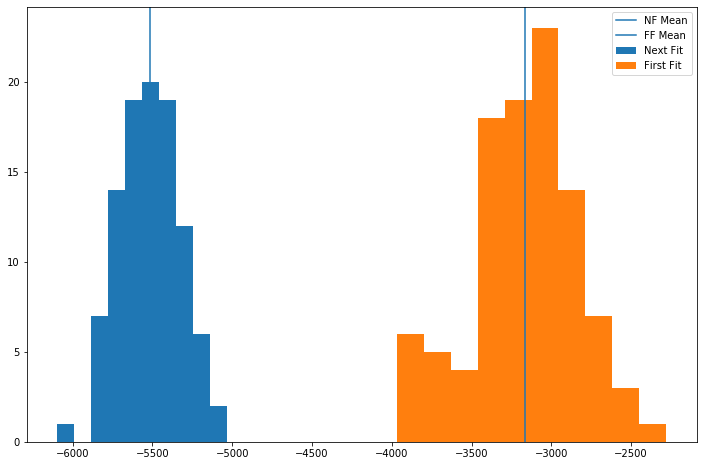

In [21]:
plt.figure(figsize=(12,8))
plt.hist(algo_rewards['NF'], label='Next Fit')
plt.axvline(algo_rewards['NF'].mean(), label='NF Mean')
plt.hist(algo_rewards['FF'], label='First Fit')
plt.axvline(algo_rewards['FF'].mean(), label='FF Mean')
plt.legend()
plt.show()

## MIP for VM Packing

In [3]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [167]:
env.step_limit = 5
env.n_pms = 10
env.reset()
m = ConcreteModel()

m.n = Set(initialize=[i for i in range(env.n_pms)]) # Num Physical Machines
m.v = Set(initialize=[i for i in range(env.step_limit)]) # Num Virtual Machines
m.t = Set(initialize=[i for i in range(env.step_limit)])
m.cpu_demand = Param(m.t,
    initialize={i: j[0] for i, j in enumerate(env.demand)})
m.mem_demand = Param(m.t,
    initialize={i: j[1] for i, j in enumerate(env.demand)})
m.durations = Param(m.v,
    initialize={i: env.step_limit - i for i in range(env.step_limit)})
min_demand = min(m.mem_demand[t] for t in m.t)
m.cpu_limit = env.cpu_capacity
m.mem_limit = env.mem_capacity
m.x = Var(m.n, m.v, m.t, within=Binary) # Assign VM's to machines

@m.Constraint(m.n, m.t)
def cpu_constraint(m, n, t):
    return sum(m.x[n, v, t] * m.cpu_demand[v] 
               for v in m.v) - m.cpu_limit <= 0

@m.Constraint(m.n, m.t)
def mem_constraint(m, n, t):
    return sum(m.x[n, v, t] * m.mem_demand[v]
               for v in m.v) - m.mem_limit <= 0

@m.Constraint(m.v)
def duration_constraint(m, v):
    return sum(m.x[n, v, t] for n in m.n for t in m.t) == m.durations[v]

@m.Constraint(m.v, m.t)
def assignment_constraint(m, v, t):
    if t >= v:
        return sum(m.x[n, v, t] for n in m.n) <= 1
    else:
        return sum(m.x[n, v, t] for n in m.n) == 0

# @m.Constraint(m.v, m.t)
# def assignment_constraint(m, v, t):
#     if v >= t:
#         return sum(m.x[n, v, t] * m.cpu_demand[v]
#                    for n in m.n) >= min_demand
#     else:
#         return Constraint.NoConstraint

# Maximize PM Packing
m.obj = Objective(expr=(
    sum(m.x[n, v, t] * (m.cpu_demand[v] - 1 + m.mem_demand[v] - 1)
        for v in m.v
        for n in m.n 
        for t in m.t)),
    sense=maximize)

solver = SolverFactory('gurobi')
results = solver.solve(m)

plan = []
for v in m.v:
    for t in m.t:
        if v == t:
            for n in m.n:
                if m.x[n, v, t].value is None:
                    continue
                if m.x[n, v, t].value > 0:
                    plan.append([n, v, t])

plan = np.vstack(plan)
print(plan)
rewards = []
actions = []
done = False
for a in plan:
    t = a[1]
    action = a[0]
    state, r, done, _ = env.step(action)
    actions.append(action)
    rewards.append(r)
    if done:
        print(sum(rewards), len(rewards), t)
        
print(m.obj.expr())

[[3 0 0]
 [5 1 1]
 [4 2 2]
 [4 3 3]
 [0 4 4]]
Step Count Reached
-19.197556659524352 5 4
-23.197556659524352


In [168]:
[(i, m.x[i].value) for i in m.x if m.x[i].value > 0]

[((0, 4, 4), 1.0),
 ((2, 2, 4), 1.0),
 ((3, 0, 0), 1.0),
 ((3, 0, 3), 1.0),
 ((3, 0, 4), 1.0),
 ((3, 3, 4), 1.0),
 ((4, 0, 1), 1.0),
 ((4, 0, 2), 1.0),
 ((4, 2, 2), 1.0),
 ((4, 3, 3), 1.0),
 ((5, 1, 1), 1.0),
 ((6, 1, 2), 1.0),
 ((6, 1, 3), 1.0),
 ((6, 1, 4), 1.0),
 ((7, 2, 3), 1.0)]

In [169]:
assignments = np.array([i for i in m.x if m.x[i].value > 0])
for i in range(env.step_limit):
    machines = assignments[np.where(assignments[:, 2]==i)[0], 0]
    print(machines)
    print("Order {} appears {} times".format(i, len(np.where(assignments[:, 1]==i)[0])))

[3]
Order 0 appears 5 times
[4 5]
Order 1 appears 4 times
[4 4 6]
Order 2 appears 3 times
[3 4 6 7]
Order 3 appears 2 times
[0 2 3 3 6]
Order 4 appears 1 times


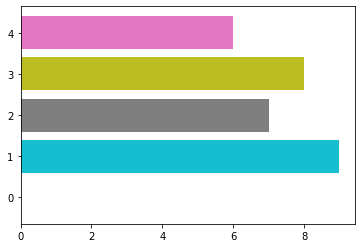

In [139]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure()
for idx in m.x:
    if m.x[idx].value > 0:
        start = idx[-1] - 1
        plt.barh(idx[-1], idx[0], color=colors[idx[0]])
        
plt.show()

In [98]:
plan = []
for v in m.v:
    for t in m.t:     
        for n in m.n:
            if m.x[n, v, t].value is None:
                continue
            if m.x[n, v, t].value > 0:
                plan.append([n, v, t])

In [99]:
plan

[[3, 0, 0],
 [6, 1, 0],
 [5, 1, 1],
 [4, 2, 0],
 [3, 2, 1],
 [1, 2, 2],
 [4, 3, 0],
 [1, 3, 1],
 [1, 3, 2],
 [0, 3, 3],
 [8, 4, 0],
 [0, 4, 1],
 [1, 4, 2],
 [0, 4, 3],
 [8, 4, 4]]

In [103]:
actions[0]

3

In [163]:
rew = np.array([m.x[n, v, t].value * (m.cpu_demand[v] - 1 + m.mem_demand[v] - 1) 
                for v in m.v 
                for n in m.n 
                for t in m.t])
rew[rew!=0].sum()

-26.36948236701787

In [164]:
x = rew[rew!=0].reshape(5, -1)
x

array([[-1.7336037 , -1.7336037 , -1.7336037 ],
       [-1.7336037 , -1.7336037 , -1.78565987],
       [-1.78565987, -1.78565987, -1.78565987],
       [-1.80829644, -1.80829644, -1.80829644],
       [-1.71697862, -1.71697862, -1.69997781]])

In [94]:
rewards

[-1.7806397024632699,
 -3.1575812919159496,
 -4.524839913032137,
 -5.902852423667337,
 -7.719032509277843]

In [ ]:
env.step_limit = 5
env.n_pms = 10
env.reset()
m = ConcreteModel()

m.n = Set(initialize=[i for i in range(env.n_pms)]) # Num Physical Machines
m.v = Set(initialize=[i for i in range(env.step_limit)]) # Num Virtual Machines
m.t = Set(initialize=[i for i in range(env.step_limit)])
m.cpu_demand = Param(m.t,
    initialize={i: j[0] for i, j in enumerate(env.demand)})
m.mem_demand = Param(m.t,
    initialize={i: j[1] for i, j in enumerate(env.demand)})
m.durations = Param(m.v,
    initialize={i: env.step_limit - i for i in range(env.step_limit)})
min_demand = min(m.mem_demand[t] for t in m.t)
m.cpu_limit = env.cpu_capacity
m.mem_limit = env.mem_capacity
m.x = Var(m.n, m.v, within=Binary) # Assign VM's to machines
m.y = Var(m.n, m.t, within=Binary) # Assign times to machines

@m.Constraint(m.n)
def cpu_constraint(m, n):
    return sum(m.x[n, v] * m.cpu_demand[v] 
               for v in m.v) - m.cpu_limit <= 0

@m.Constraint(m.n)
def mem_constraint(m, n):
    return sum(m.x[n, v] * m.mem_demand[v]
               for v in m.v for t in m.t) - m.mem_limit <= 0

@m.Constraint(m.n, m.v)
def duration_constraint(m, n, v):
    return sum(m.x[n, v, t] for t in m.t) == m.durations[v]

@m.Constraint()
def time_constraint(m):
    return sum(m.x[n, v, t])
# @m.Constraint(m.v, m.t)
# def assignment_constraint(m, v, t):
#     if v >= t:
#         return sum(m.x[n, v, t] * m.cpu_demand[v]
#                    for n in m.n) >= min_demand
#     else:
#         return Constraint.NoConstraint

# Maximize PM Packing
m.obj = Objective(expr=(
    sum(m.x[n, v, t] * (m.cpu_demand[v] - 1 + m.mem_demand[v] - 1)
        for v in m.v
        for n in m.n 
        for t in m.t)),
    sense=maximize)

solver = SolverFactory('gurobi')
results = solver.solve(m)

plan = []
for v in m.v:
    for t in m.t:
        if v == t:
            for n in m.n:
                if m.x[n, v, t].value is None:
                    continue
                if m.x[n, v, t].value > 0:
                    plan.append([n, v, t])

plan = np.vstack(plan)
rewards = []
actions = []
done = False
for a in plan:
    t = a[1]
    action = a[0]
    state, r, done, _ = env.step(action)
    actions.append(action)
    rewards.append(r)
    if done:
        print(sum(rewards), len(rewards), t)
        break

$$\textrm{max}\; \sum_n \sum_v \sum_t x_{nvt} (D^c_v + D^m_v - 2)$$

$$\textrm{s.t.} \;$$